<a href="https://colab.research.google.com/github/Speech-to-text-tenac/STT/blob/feature_extraction/notebooks/feature_extration(STT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feature Extraction**
Every audio signal consists of many features. However, we must extract the characteristics that are relevant to the problem we are trying to solve. The process of extracting features to use them for analysis is called feature extraction. This notebook loads an audio using Librosa library and defines a function to generate spectograms and MFCCs. Spectograms and MFCCs are the features we are intrested in in the audios.

### Clone the data repo
Cloning the data repo

In [ ]:
!git clone https://github.com/getalp/ALFFA_PUBLIC.git

Cloning into 'ALFFA_PUBLIC'...
remote: Enumerating objects: 66044, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 66044 (delta 8), reused 1 (delta 0), pack-reused 66024
Receiving objects: 100% (66044/66044), 6.54 GiB | 32.16 MiB/s, done.
Resolving deltas: 100% (12345/12345), done.
Checking out files: 100% (56926/56926), done.


In [ ]:
!du -sh ALFFA_PUBLIC/

16G	ALFFA_PUBLIC/


In [ ]:
!du -sh ALFFA_PUBLIC/ASR/*

2.5G	ALFFA_PUBLIC/ASR/AMHARIC
824M	ALFFA_PUBLIC/ASR/FONGBE
11M	ALFFA_PUBLIC/ASR/HAUSA
124K	ALFFA_PUBLIC/ASR/LREC2016_DataCollection_And_ALFFA_Project.pdf
1.5G	ALFFA_PUBLIC/ASR/SWAHILI
2.7G	ALFFA_PUBLIC/ASR/WOLOF


### Mount the drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Copy the folder you need to your drive folder

In [ ]:
!cp -r ALFFA_PUBLIC/ASR/AMHARIC ALFFA_PUBLIC/ASR/SWAHILI drive/MyDrive/Week-4-STT/data/

In [ ]:
!du -sh drive/MyDrive/Week-4-STT/data/*

2.4G	drive/MyDrive/Week-4-STT/data/AMHARIC
1.4G	drive/MyDrive/Week-4-STT/data/SWAHILI


### Change to the Amharic folder 
The folder contains the data for Amharic Language

In [ ]:
import os
os.chdir("/content/drive/My Drive/Week-4-STT/data/AMHARIC")
os.listdir()

['README.md', 'data', 'kaldi-script', 'lang', 'lm']

In [ ]:
!pip install librosa
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=781ef5485d033b3372dd8265d495d5ab9b892d19a7688a7d93bea170ca0beb34
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


## Import the required Packages

In [ ]:
import numpy as np
from tensorflow import keras
import soundfile
import json

import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display  as ipd

from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)
from keras.utils.vis_utils import plot_model


import _pickle as pickle
from numpy.lib.stride_tricks import as_strided

import sklearn

from keras.layers import (Input, Lambda)
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import os

In [ ]:
train_audio_path = 'data/train/wav/'
audio, rate = librosa.load(train_audio_path+'tr_24_tr01024.wav')
print("audio: ", audio)
print("Sampling rate: ", rate)

audio:  [-0.00402958 -0.00456451 -0.00402832 ... -0.00409809 -0.00473323
 -0.0030876 ]
Sampling rate:  22050


In [ ]:
ipd.Audio(audio, rate=rate)

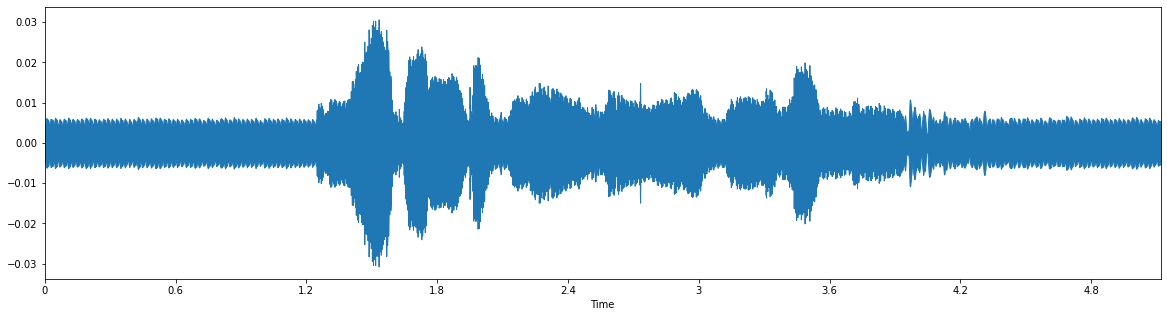

In [ ]:
%matplotlib inline
import librosa.display
#Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(audio, sr=rate)

## Utility Functions
We define utility functions to help us in feature extraction
The utility functions defined below are:
  

1.   **spectogram()** - Computes the spectogram for an audio signal
2.   **plot_spectogram()** - This function plots a normalized spectogram of an audio signal
3.   **mfcc()** - This function computes the Mel frequency cepstral coefficients (MFCCs) of an audio signal
4.   **plot_mfcc()** - This function plots the mfccs of an audio signal




In [ ]:
from numpy.lib.stride_tricks import as_strided
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram
    
    This code was obtained from the notebook provided by @Desmond, one of the tutors at 10Academy batch 5 training

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [ ]:
x,freqs= spectrogram(audio)
freqs

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_spectrogram(vis_spectrogram_feature):
  """
  This function plots a normalized spectogram
  This code was obtained from the notebook provided by @Desmond, one of the tutors at 10Academy batch 5 training


  Args:
  vis_spectogram_feature: 2D array of the spectogram to visualize
  """
  # plot the normalized spectrogram
  fig = plt.figure(figsize=(12,5))
  ax = fig.add_subplot(111)
  im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
  plt.title('Spectrogram')
  plt.ylabel('Time')
  plt.xlabel('Frequency')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, cax=cax)
  plt.show()

In [ ]:
def mfcc(audio, sampling_rate):
  """
  This function computes the Mel frequency cepstral coefficients (MFCCs) of an audio signal

  Precondition:
    librosa is installed in the active environmen

  Args:
    audio: (1D array) The input audio signal
    sampling_rate: (scalar) The sampling rate of the audio signal
  """
  import librosa
  return librosa.feature.mfcc(audio, sr=sampling_rate)





In [ ]:
def plot_mfcc(mfccs, sampling_rate):
  """
  This function plots the mfccs of an audio signal

  Precondition:
    librosa is installed in the active environment

  Args:
    mfccs: Mel frequency cepstral coefficient of the audio signal
    sampling_rate: (scalar) The sampling rate of the audio signal
  """
  librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')

#### **Spectogram extraction for our selected audio**
A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

We can display a spectrogram using. librosa.display.specshow.
We compute the spectogram of the audio signal we loaded and plot the spectogram feature

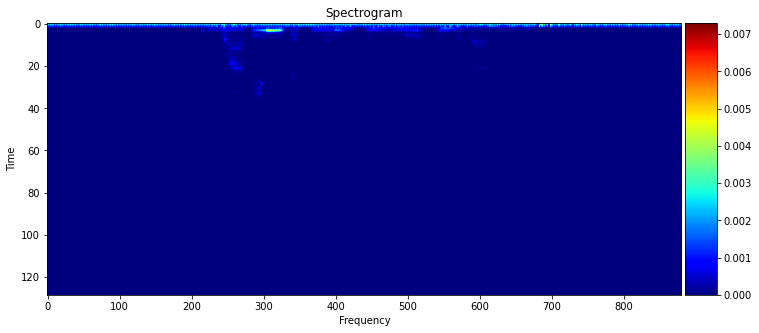

In [ ]:
x,freqs= spectrogram(audio)  # compute the spectrogram of the audio
plot_spectrogram_feature(x)  # plot the spectogram

### **MFCC extraction for our selected audio**
WE compute of the loaded signal and plot the mfcc

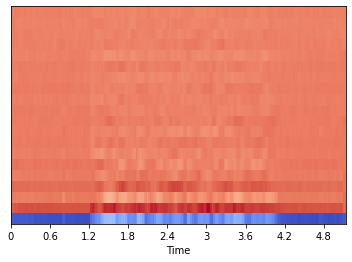

In [ ]:
mfccs = mfcc(audio, rate) # compute the mfcc
plot_mfcc(mfccs, rate)

### **Other spectral Feature extraction**


1. **Spectral Centroid**

The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the ” center of mass” for a sound is located. 

In [ ]:
def spectral_centroids(audio, sampling_rate):
  """
  computes the spectral centroid for each frame in an audio signal and the time variable for visualization
  """
  spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sampling_rate)
  frames = range(len(spectral_centroids[0]))
  t = librosa.frames_to_time(frames)
  return spectral_centroids, t

Plotting the spectral centroid for our input signal we loaded

In [ ]:
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

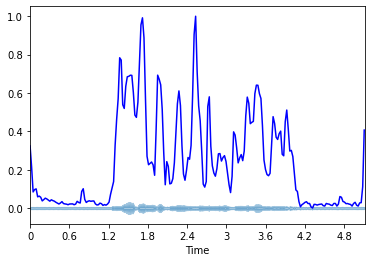

In [ ]:
spectral_centroid, t = spectral_centroids(audio, rate)
spectral_centroid= spectral_centroid[0]

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(audio, sr=rate, alpha=0.4)
#plt.figure(figsize=(12, 4))
plt.plot(t, normalize(spectral_centroid), color='b')





**2. Spectral Rolloff**

It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies.



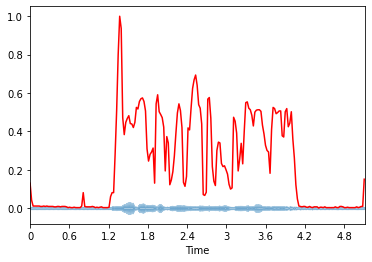

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01, sr=rate)[0]
#plt.figure(figsize=(12, 4))
librosa.display.waveplot(audio, sr=rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

**3. Spectral Bandwidth**

The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.

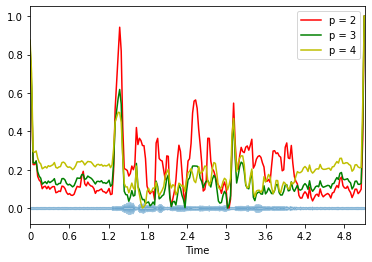

In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(audio+0.01, sr=rate)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(audio+0.01, sr=rate, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(audio+0.01, sr=rate, p=4)[0]
#plt.figure(figsize=(15, 9))
librosa.display.waveplot(audio, sr=rate, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

**4. Chroma feature**

A chroma feature or vector is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal. In short, It provides a robust way to describe a similarity measure between music pieces.

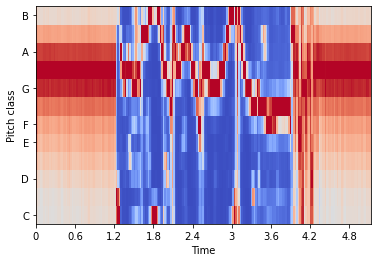

In [58]:
chromagram = librosa.feature.chroma_stft(audio, sr=rate, hop_length=512)
#plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')